# Using the SEBA Algorithm together with Linear Response for the Ocean System (SEBA Part 2)

This is the second part of a two notebook discussion of using SEBA together with Linear Response in Julia. In the first part, we illustrated the ideas on the conceptionally simpler Double Gyre System, and now we will try to apply this to a system determined by real world ocean data. As parameter we will use the **stoptime**, just as in the Double Gyre example, not some more sophisticated parameter like wind etc., in order to increase the difficulty just one step at a time.

## Setup

In [1]:
include("../../src/CoherentStructures.jl")

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [69]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
ϵ                      = 5               # perturbation
nev                    = 10               # number of eigenvalues
t_initial              = minimum(Time)  
t_end                  = t_initial+75     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [42]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
# standard domain from the literature
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
# homogeneous Dirichlet boundary conditions to avoid intersection with the boundary of the domain
bdata = getHomDBCS(ctx, "all");

## Compute Eigenfunctions and Linear Response

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

 89.522580 seconds (91.93 M allocations: 5.215 GiB, 1.49% gc time)


In [70]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

1100.068378 seconds (111.05 M allocations: 8.897 GiB, 0.13% gc time)


In [71]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);
λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

## Some first plots

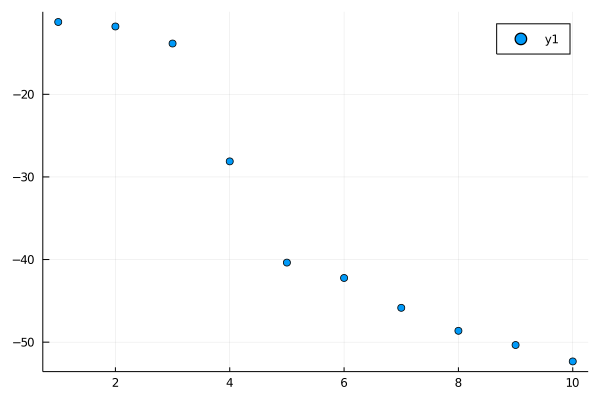

In [12]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [72]:
#Eigengap after 3 eigenvalues
nev = 3
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [73]:
for i in 1:nev
    print("exact ev0"*string(i)*": "*string(round(λ₀[i],digits=5))*
        "\t exact evϵ"*string(i)*": "*string(round(λϵ[i],digits=5))*
        "\t predicted ev"*string(i)*": "*string(round(λ₀[i] + ϵ*λ_dot[i],digits=5))*
        "\t relative error: "*string(round(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]),digits=5))*"\n")
end

exact ev01: -11.24666	 exact evϵ1: -12.26069	 predicted ev1: -12.20356	 relative error: 0.00466
exact ev02: -11.78993	 exact evϵ2: -12.37386	 predicted ev2: -12.36772	 relative error: 0.0005
exact ev03: -13.85271	 exact evϵ3: -14.68388	 predicted ev3: -12.37915	 relative error: 0.15696


In [74]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-1.0, -1.0, -1.0, -1.0,-1.0]
cmaxs =     -cmins
cmins_lr =  [-0.01, -0.01, -0.01, -0.01, -0.5]
cmaxs_lr =  -cmins_lr;

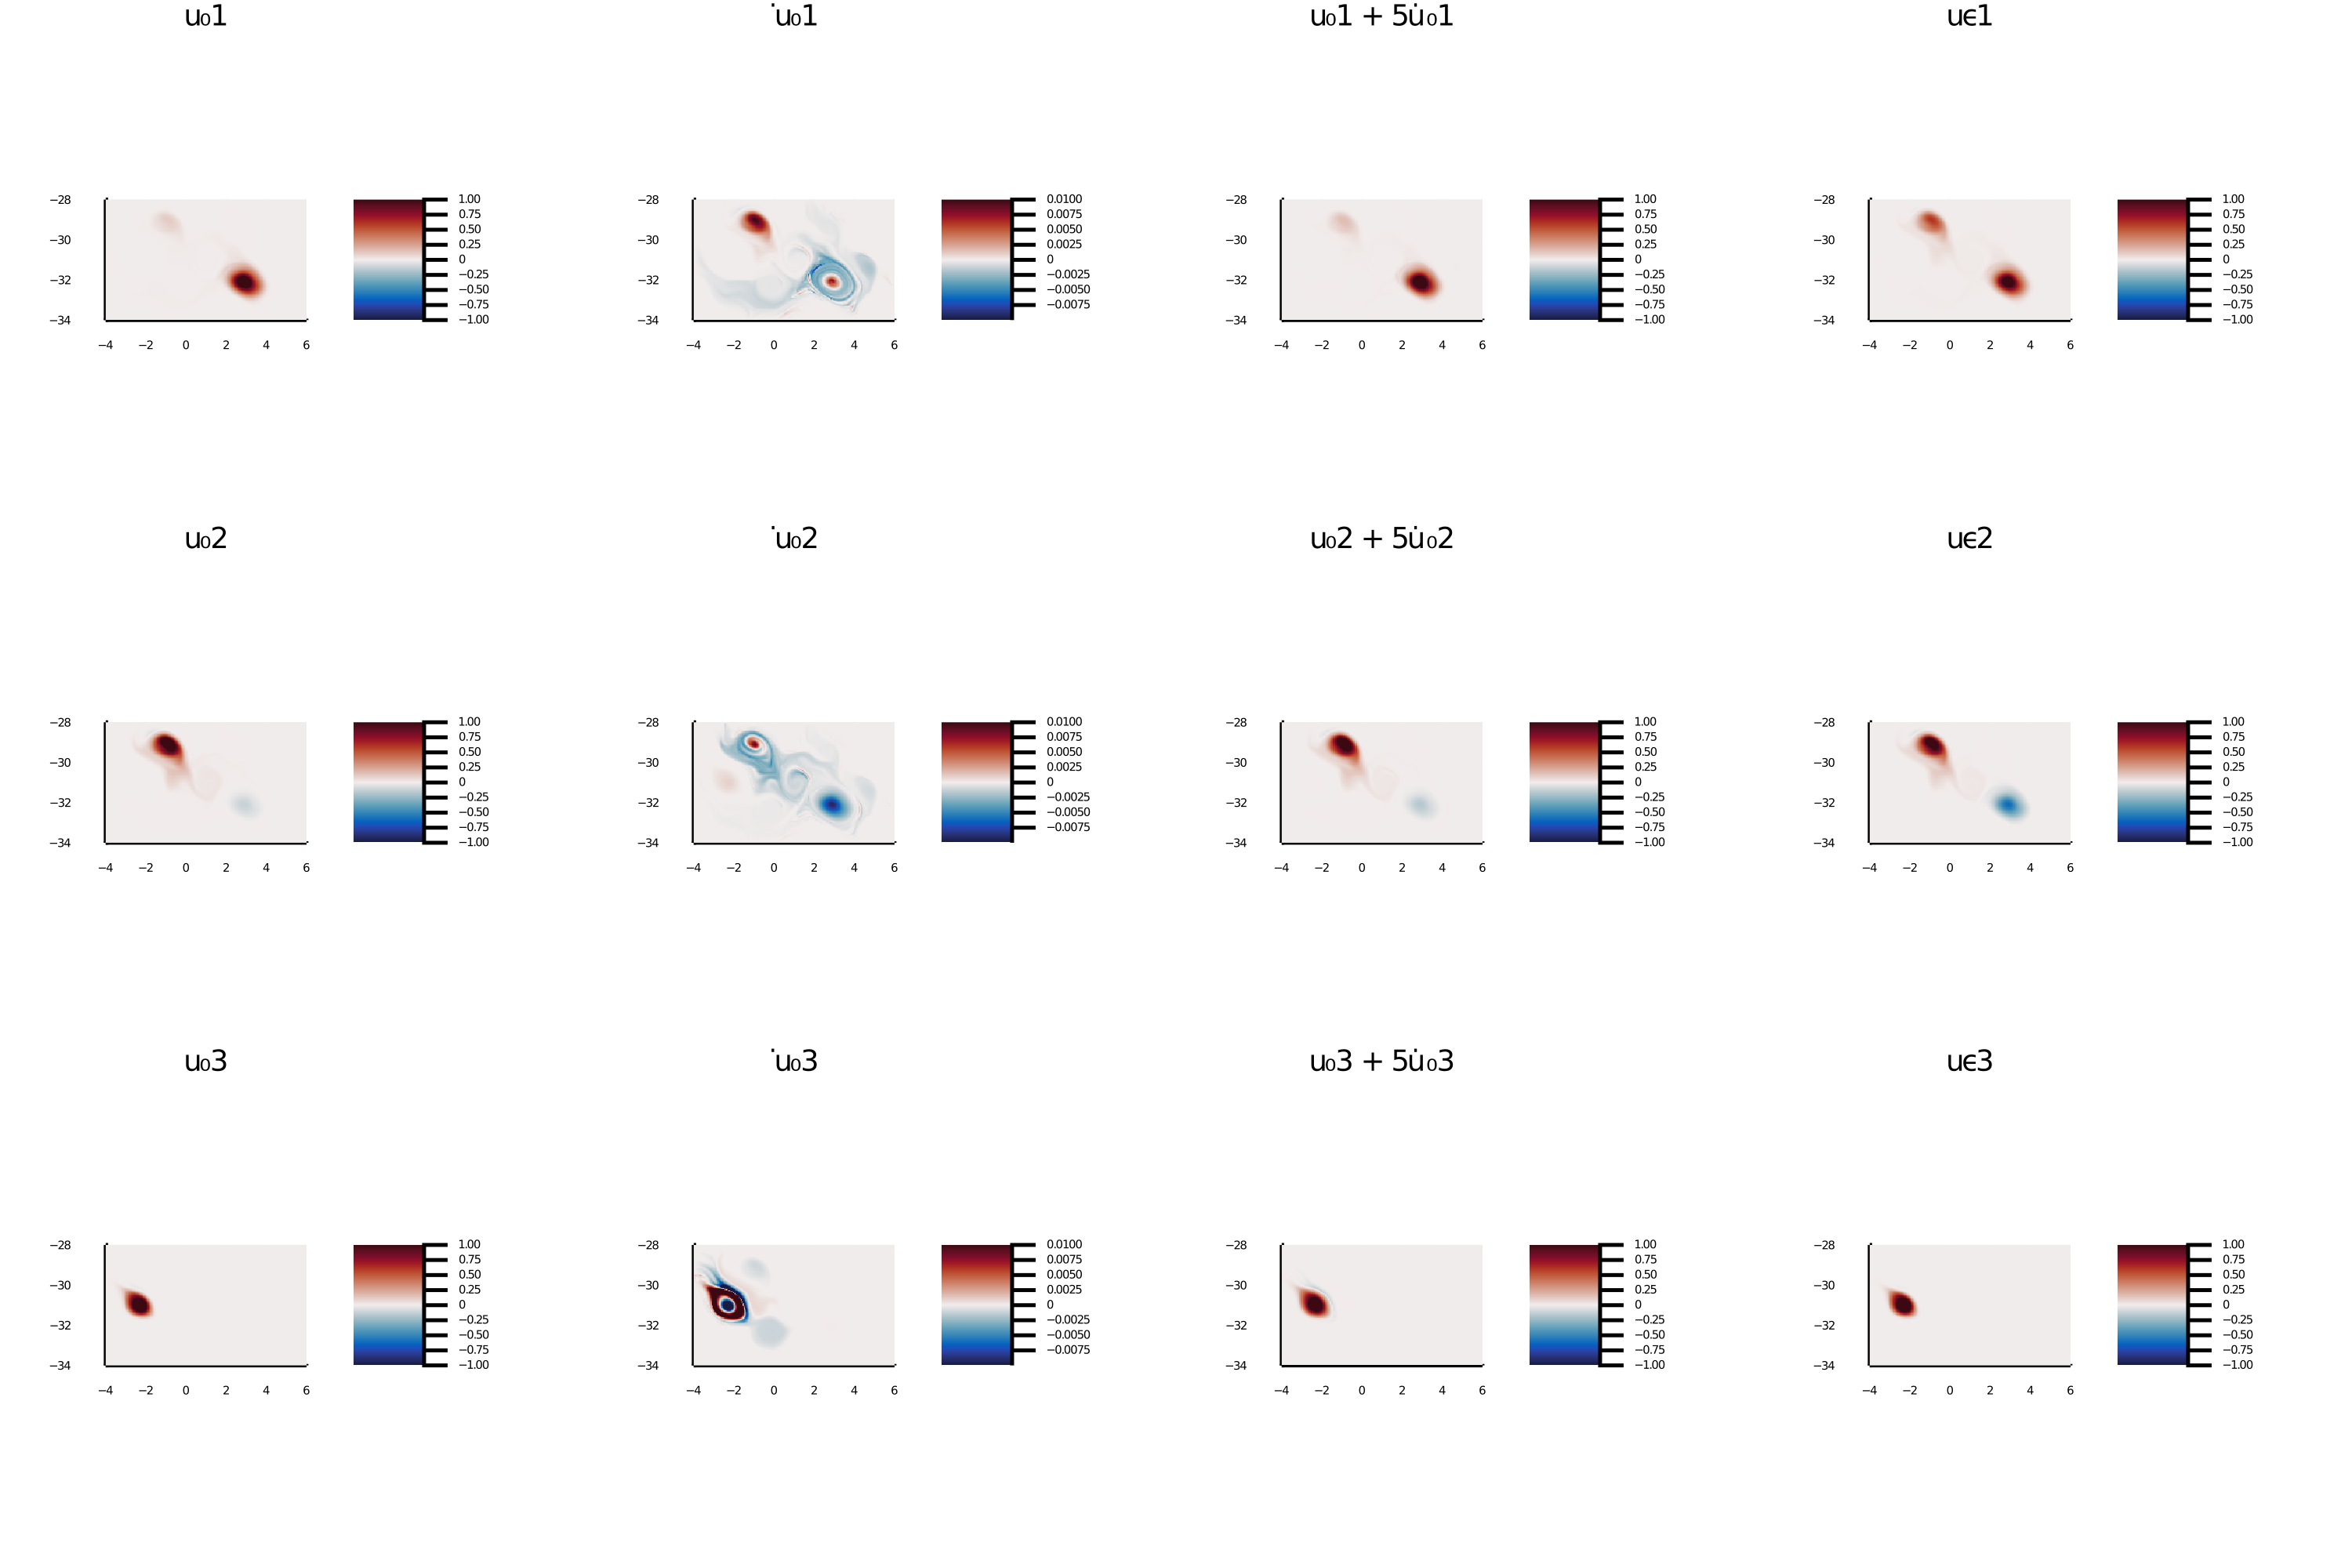

In [75]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lat_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [76]:
#limit ourselves to one ev for plotting etc.
ev = 1

1

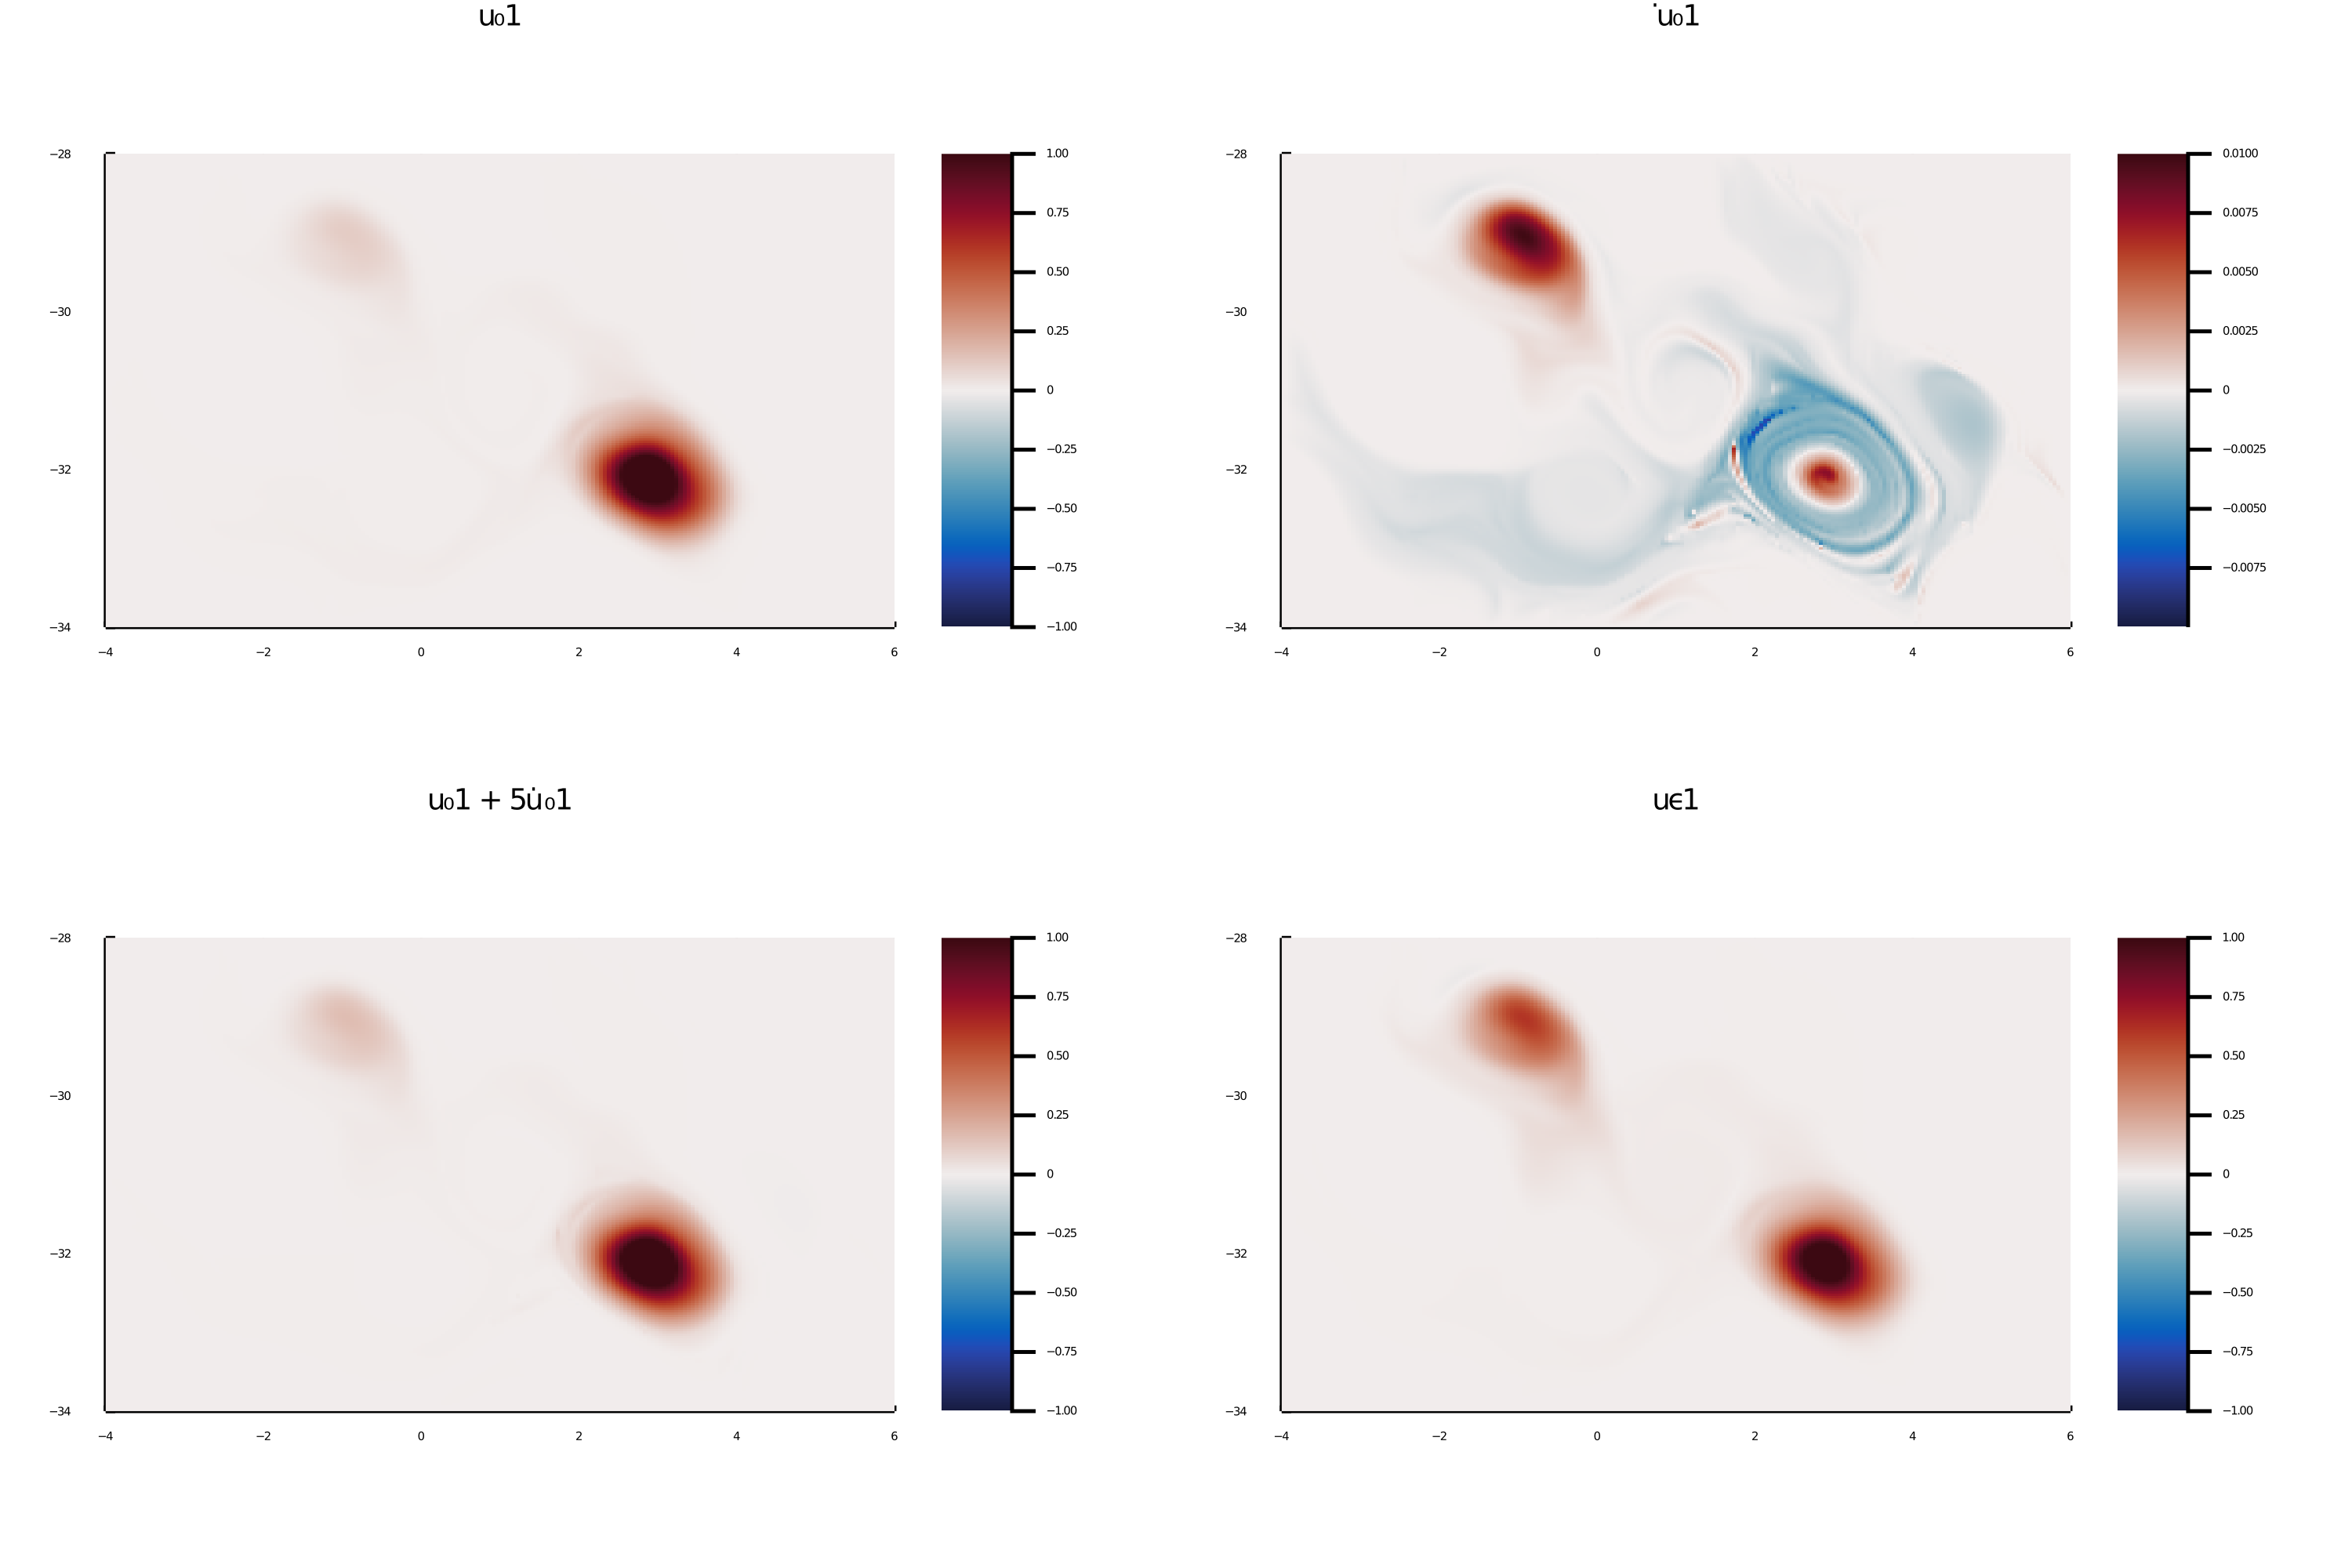

In [77]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  grid_resolution, grid_resolution, 
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [78]:
using Contour
using PyCall
using PyPlot
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

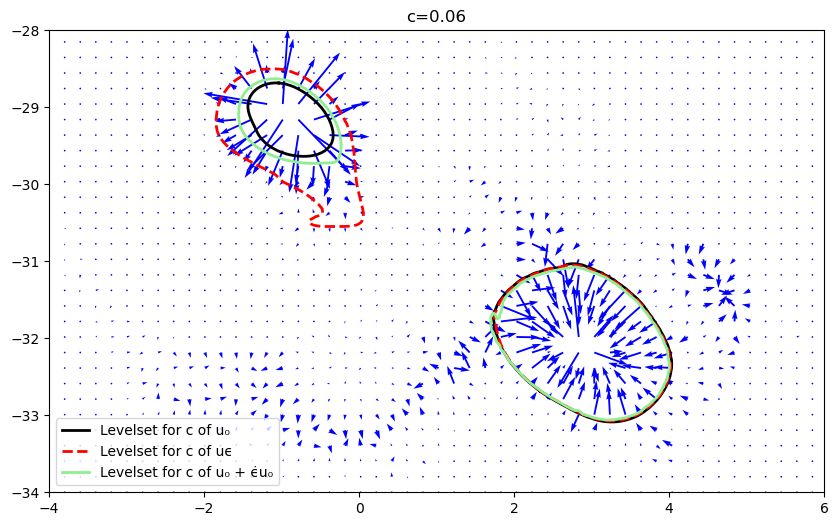

In [79]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value, bdata=bdata,
    n_candidates=1000,min=0)

c_best = level(best_levelset)

plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev], bdata=bdata)...,ax,scale=0.1,step=4)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best, bdata=bdata))

ax.plot([],[],color=:black,linewidth=2, label="Levelset for c of u₀")
for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end

ax.plot([],[],color=:red,linestyle="--",linewidth=2, label="Levelset for c of uϵ")
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end

ax.plot([],[],color=:lightgreen,linewidth=2, label="Levelset for c of u₀ + ϵ̇u₀")
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))")
ax.legend();

## SEBA

As we can see, the different eigenfunctions do not really correspond to a nice partition into the individual gyres we can see visually, and in addition, it can be hard to match those at t and t+ϵ. For this, again, the SEBA algorithm could come to the resuce, but we need to see whether we can still compute the linear responses for these new partitions:

In [80]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))

normalizeU (generic function with 1 method)

In [81]:
using LinearAlgebra

In [82]:
# standard heuristic
μ = 0.99/sqrt(lon_resolution*lat_resolution);

In [83]:
@time S, O = SEBA(u₀,μ=μ,returnR=true,sort=false);

  0.005825 seconds (604 allocations: 16.081 MiB)


In [84]:
Sϵ, Oϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [85]:
#The SEBA outputs, but without thresholding and rescaling, so that they are comparable to S_dot
S′ = Matrix(qr(u₀).Q)*O'
Sϵ′ = Matrix(qr(uϵ).Q)*Oϵ';

In [86]:
# This is the matrix we effectively multiply u₀ with
inv(qr(u₀).R)*O'

3×3 Array{Float64,2}:
  0.0500832    0.00442433  -3.62045e-7
 -0.00442394   0.0500673   -1.2223e-5
  7.17776e-7  -1.21985e-5  -0.0502433

In [87]:
inv(qr(uϵ).R)*Oϵ'

3×3 Array{Float64,2}:
 -0.0449059    0.022603    -7.49395e-6
  0.0226092    0.0448902   -1.36013e-5
  5.73125e-7  -1.55088e-5  -0.0502409

In [88]:
S_dot = u_dot*inv(qr(u₀).R)*O';

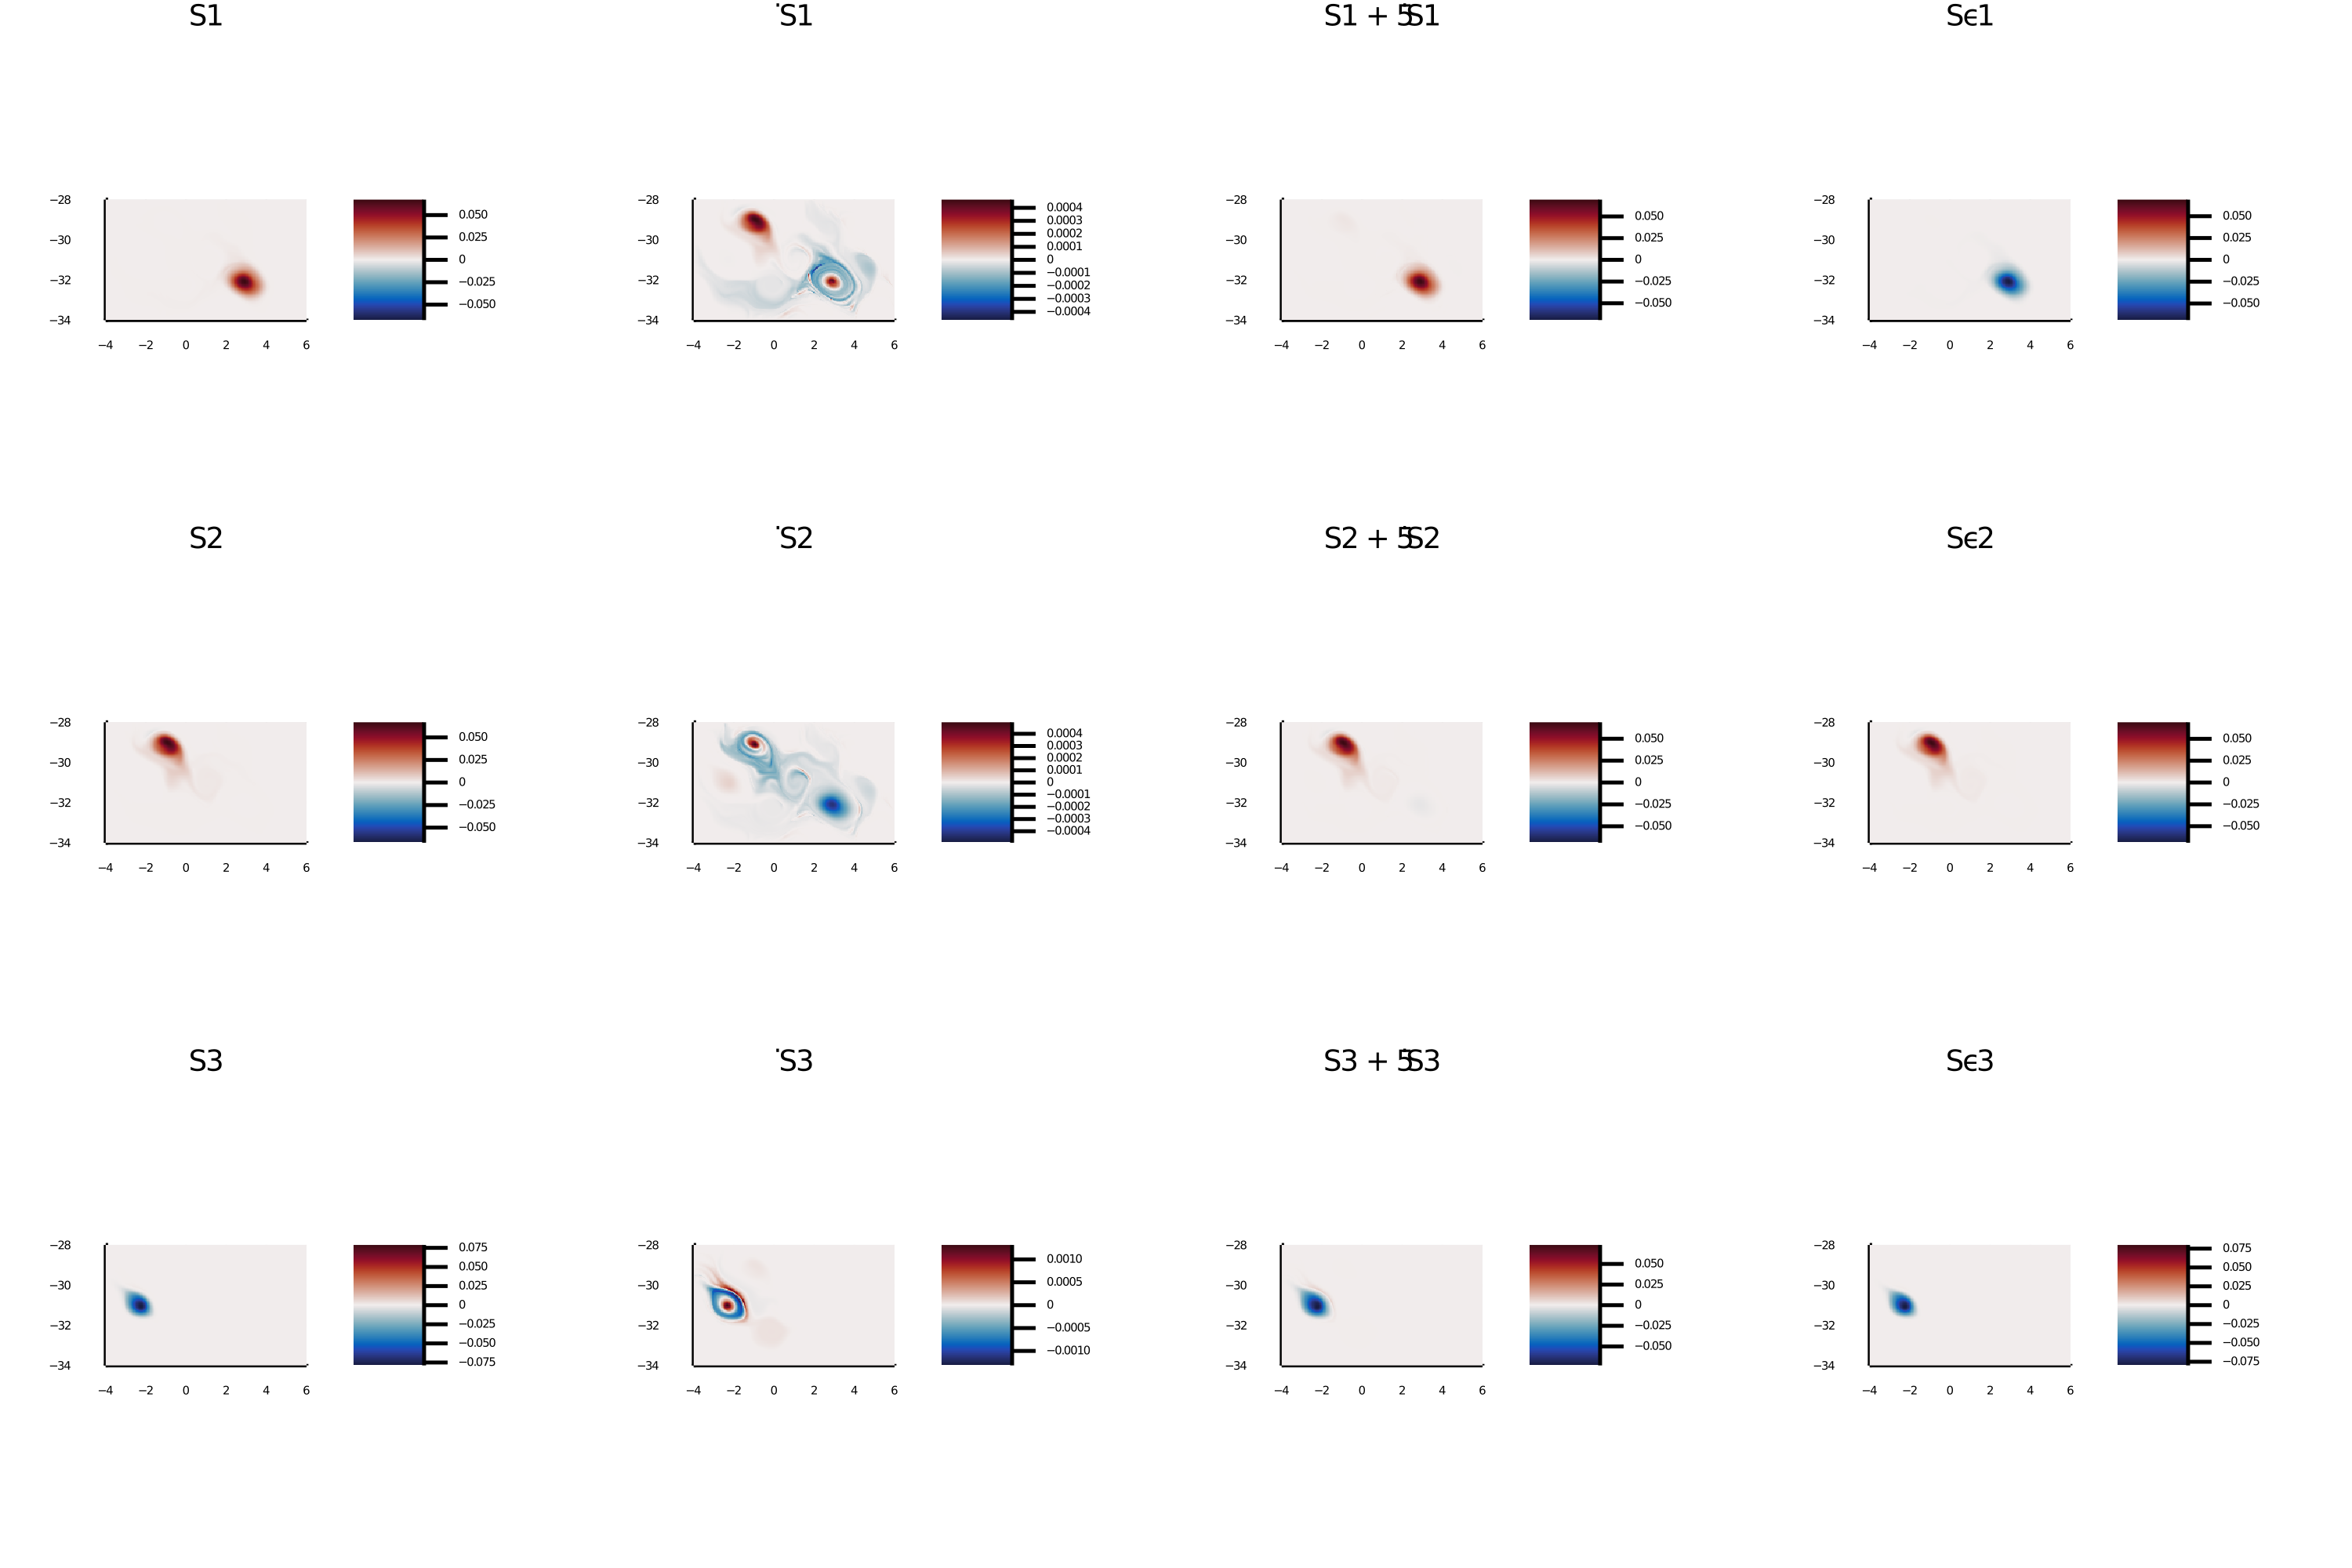

In [89]:
#for S′ and Sϵ′, we have a linear response, namely S_dot 
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S′[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,i])),maximum(abs.(S′[:,i]))),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, S_dot[:,i], 
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,i])),maximum(abs.(S_dot[:,i]))), 
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, S′[:,i] + ϵ*S_dot[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,i] + ϵ*S_dot[:,i])),maximum(abs.(S′[:,i] + ϵ*S_dot[:,i]))), 
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ′[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(Sϵ′[:,i])),maximum(abs.(Sϵ′[:,i]))), 
            xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

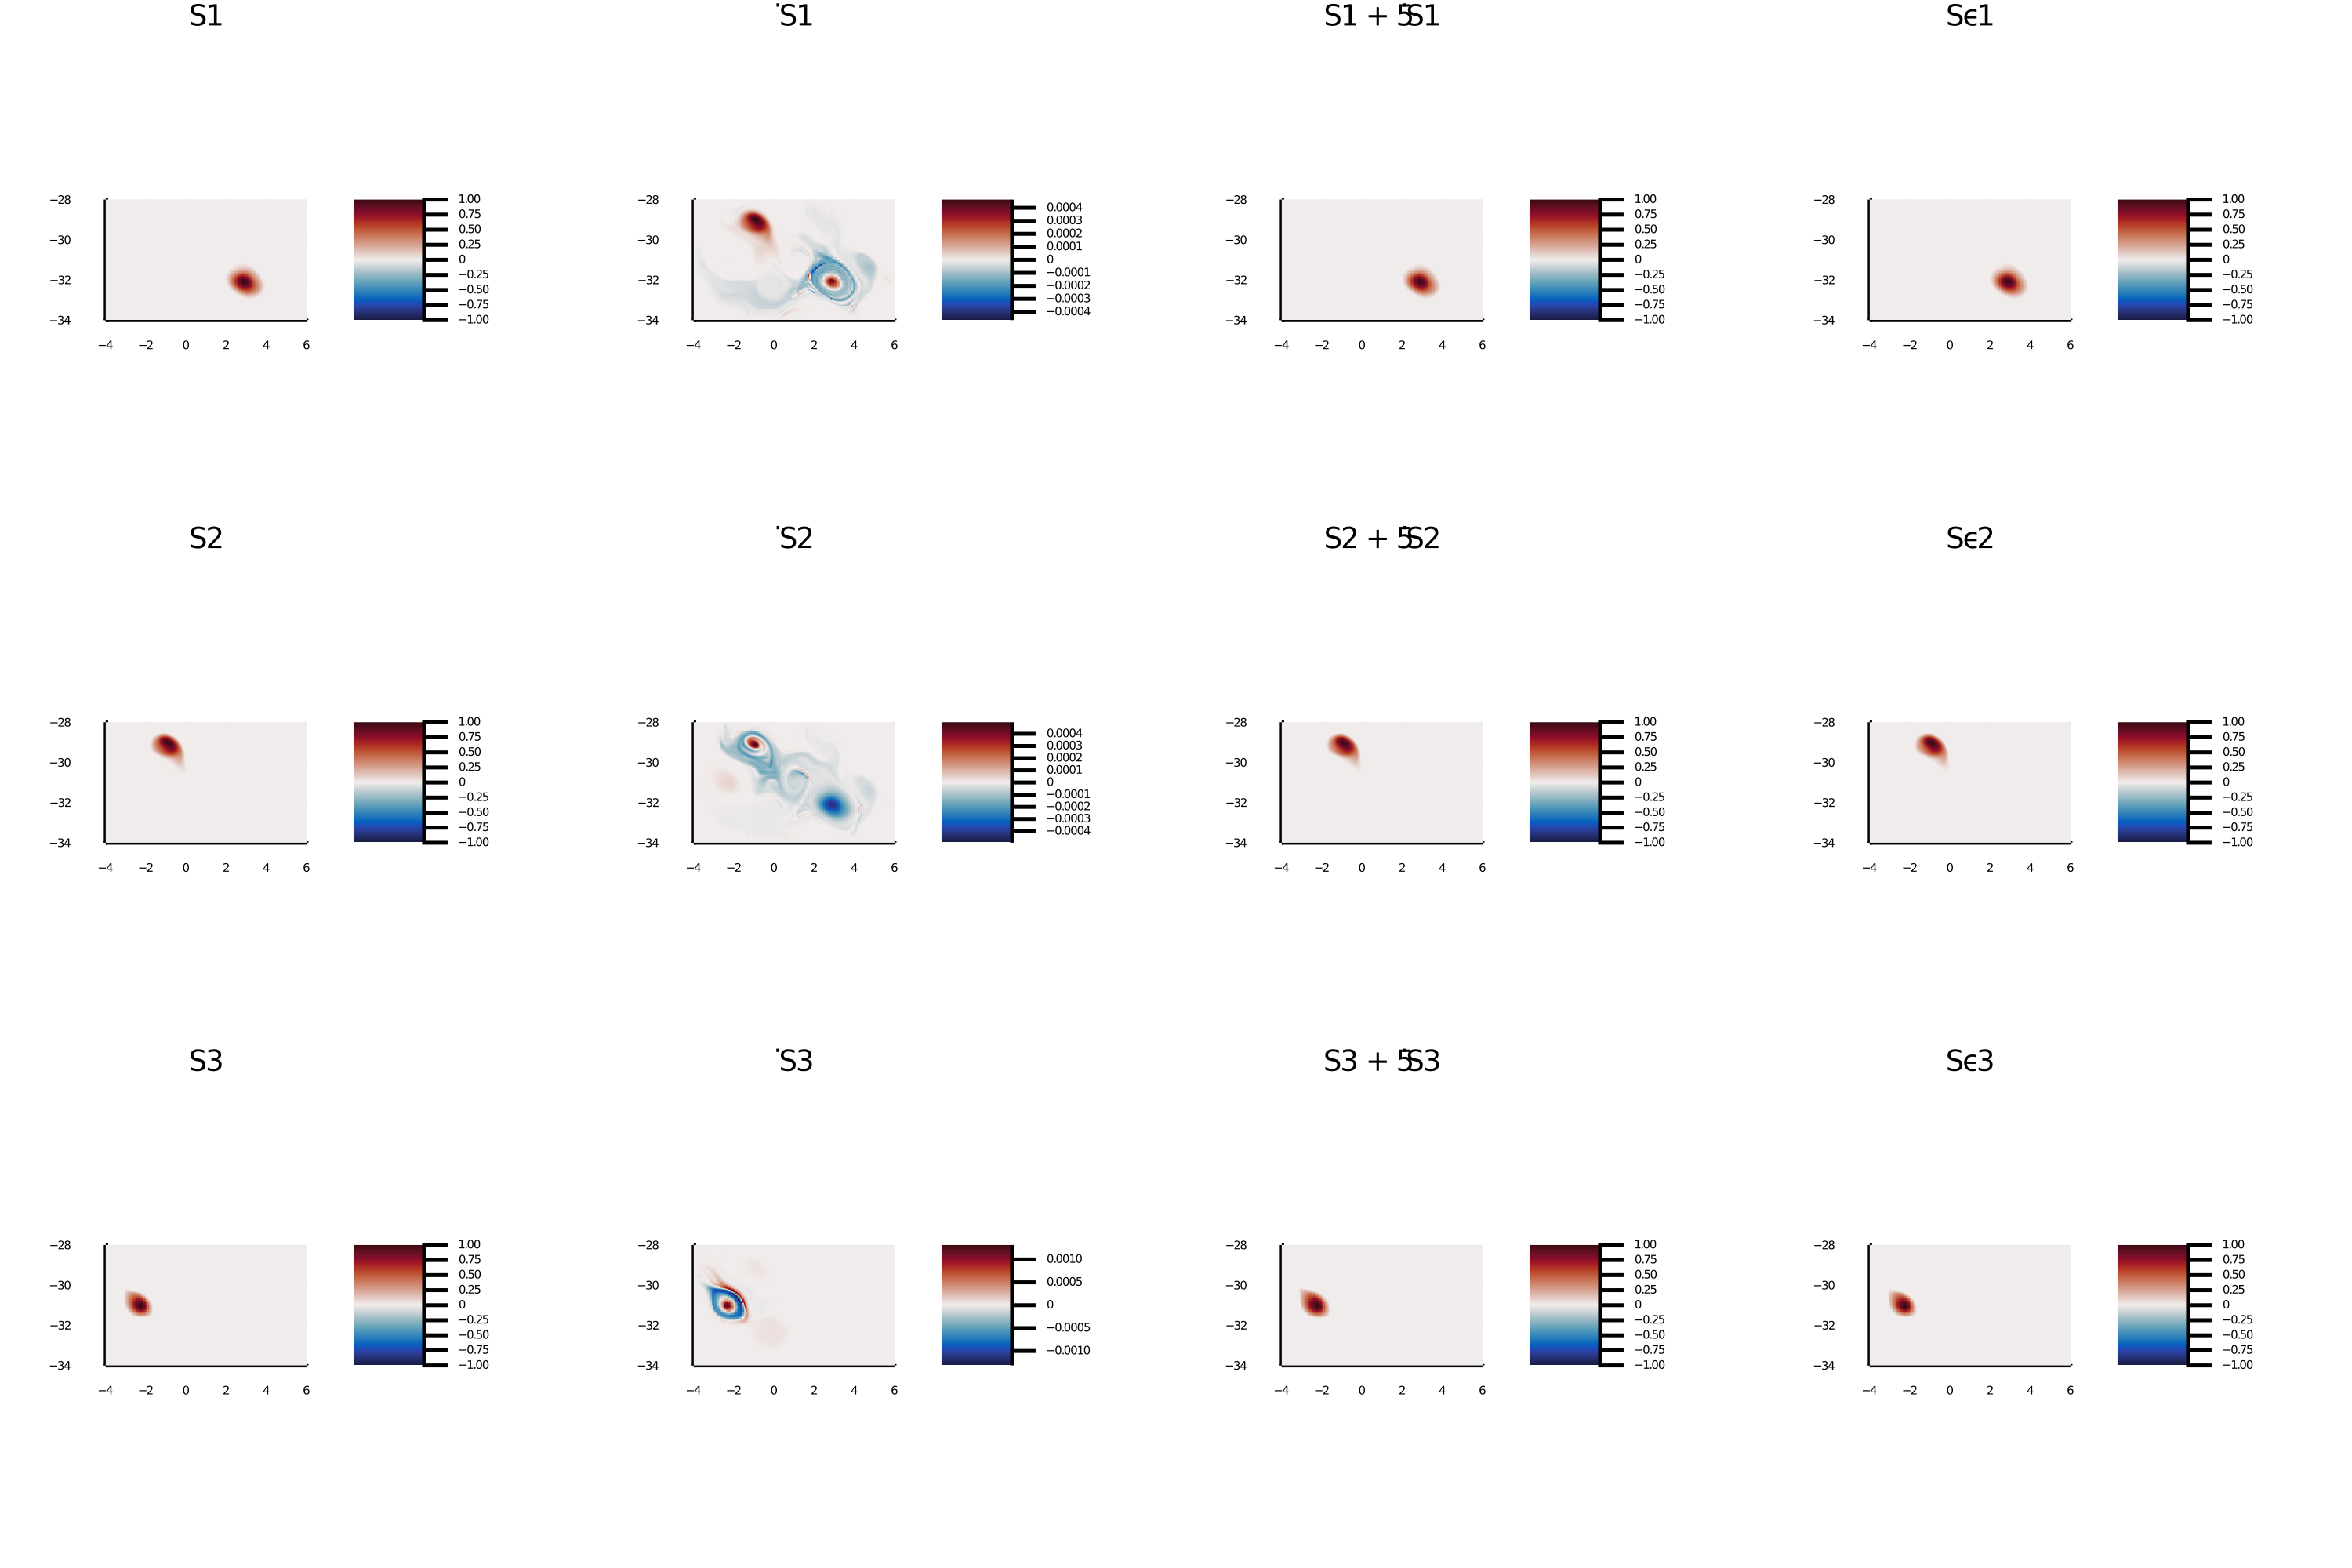

In [90]:
# to get a prediction for Sϵ from S and S_dot, we simply apply soft thresholding and normalization to the previous example
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, S_dot[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,i])),maximum(abs.(S_dot[:,i]))),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [91]:
#again, select one index for closer inspection
ev = 2

2

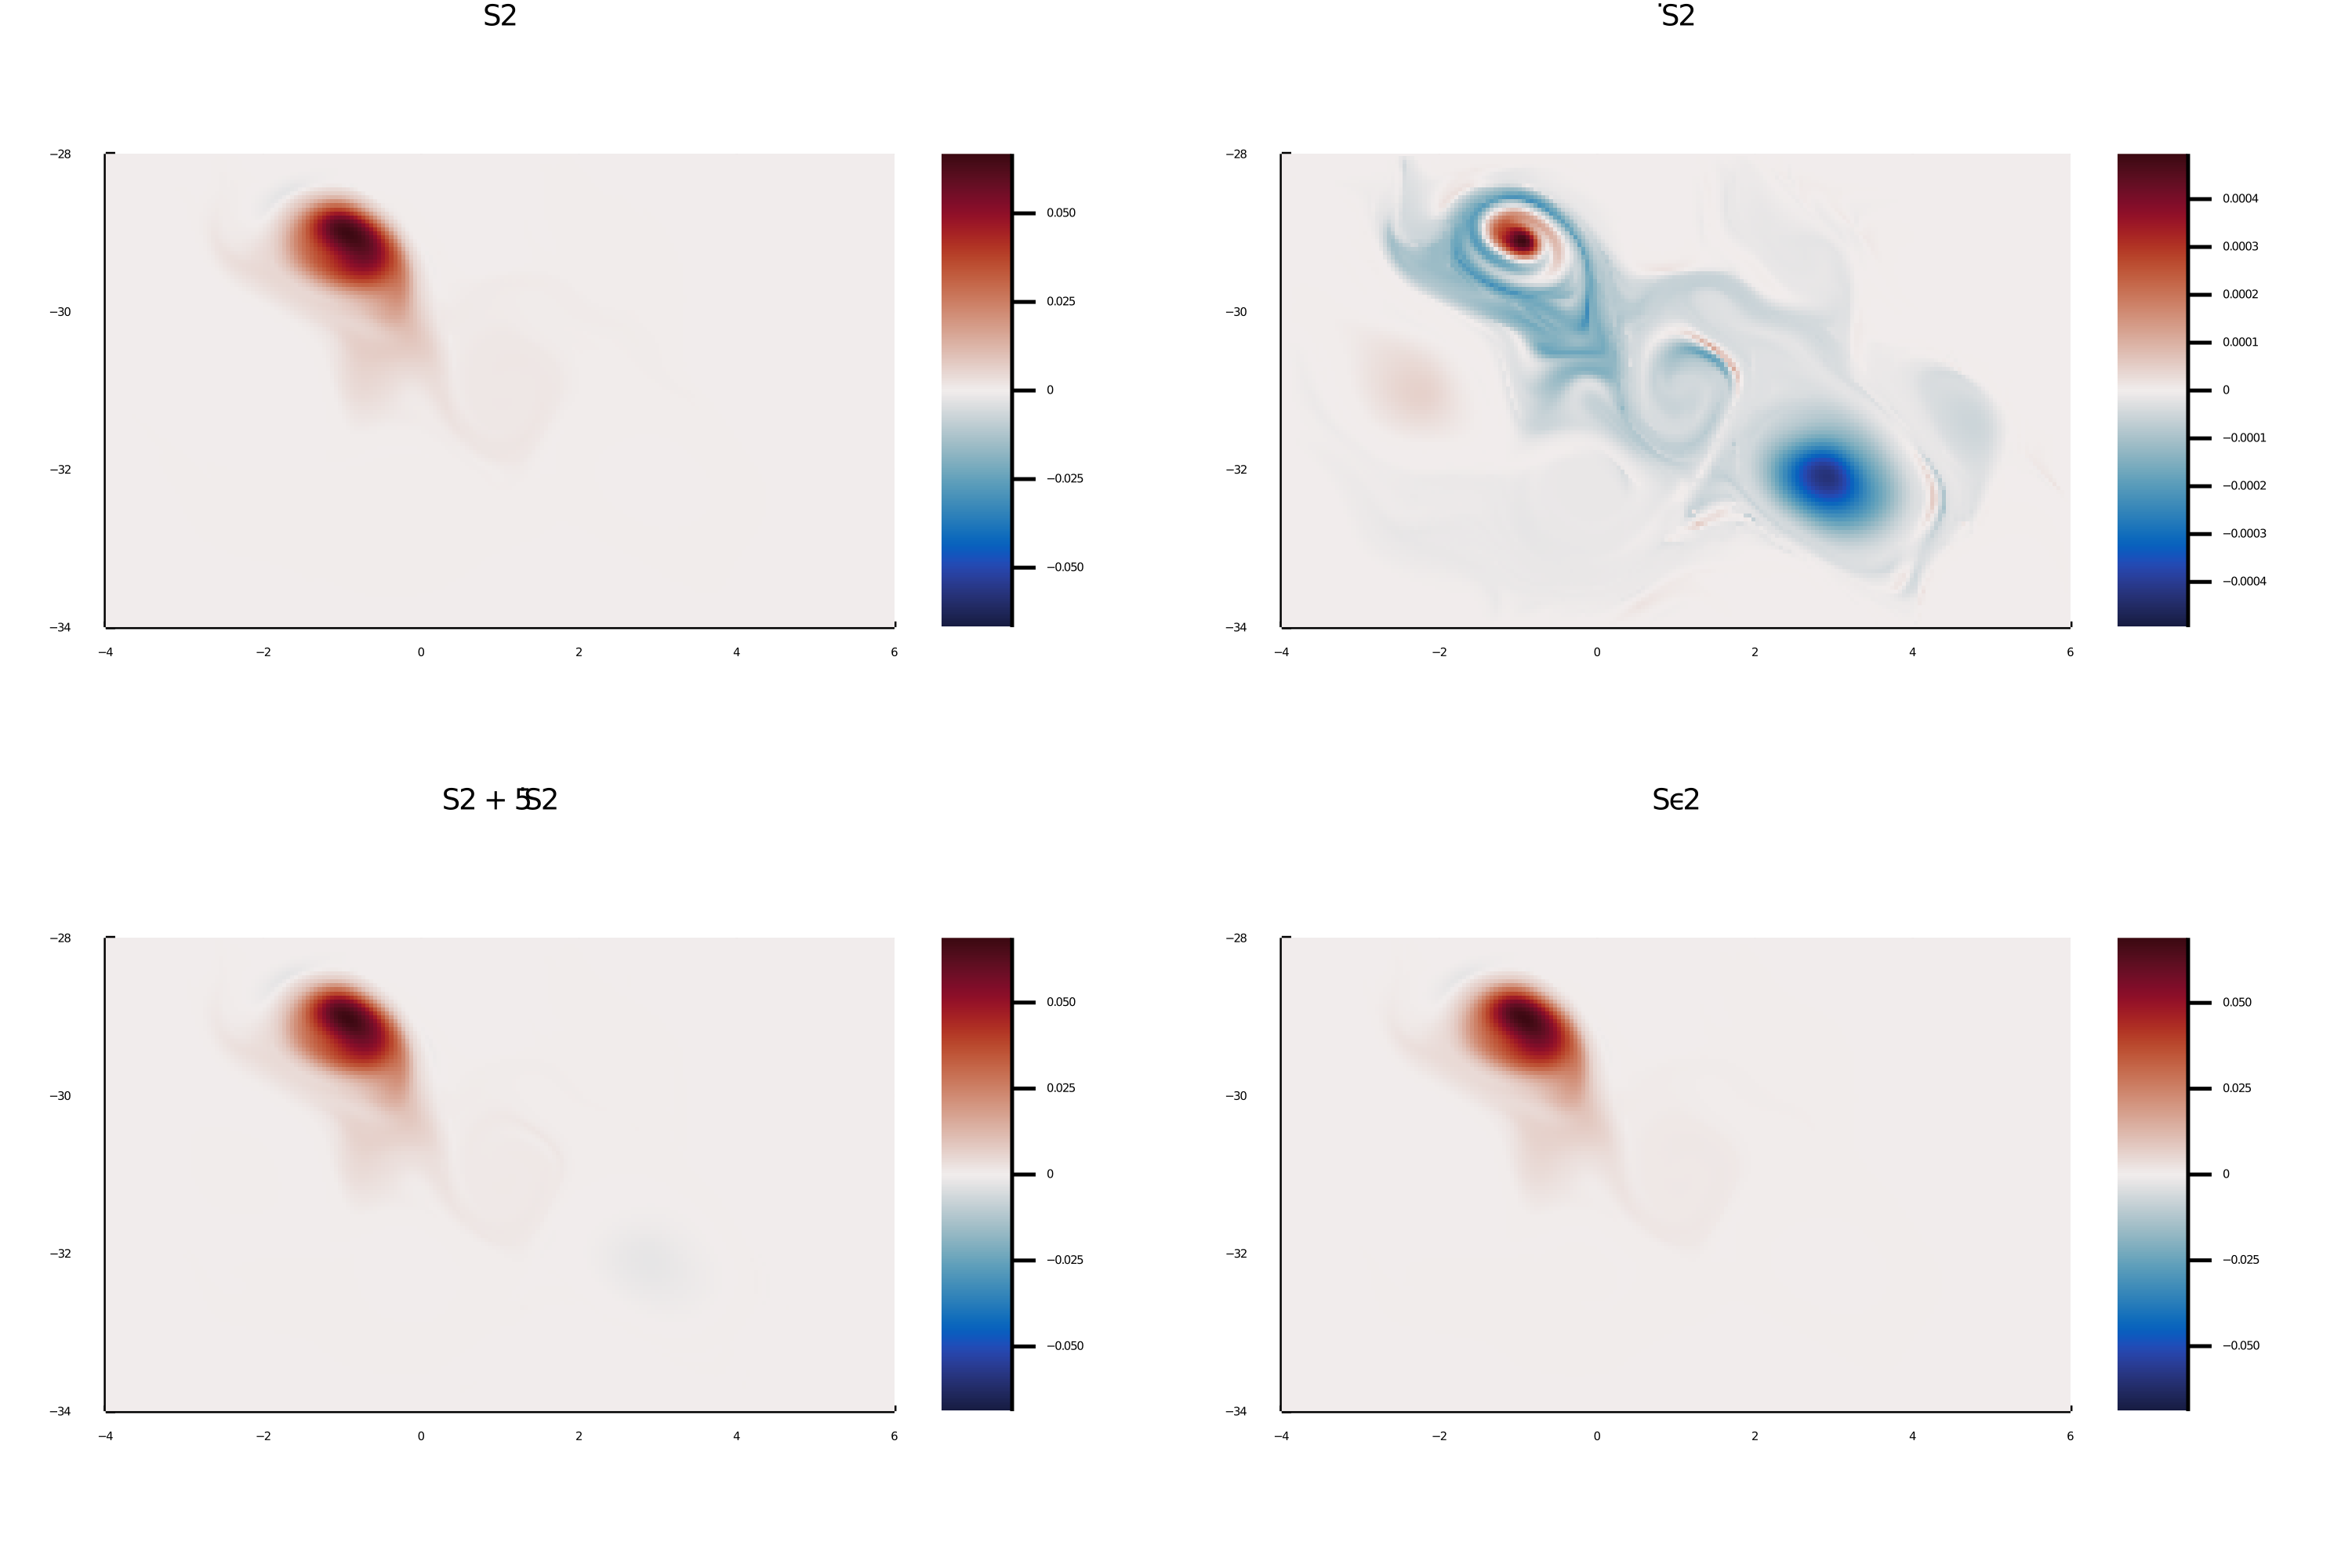

In [92]:
plots = []
push!(plots,plot_u(ctx, S′[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,ev])),maximum(abs.(S′[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, S_dot[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,ev])),maximum(abs.(S_dot[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, S′[:,ev] + ϵ*S_dot[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,ev] + ϵ*S_dot[:,ev])),maximum(abs.(S′[:,ev] + ϵ*S_dot[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ′[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(Sϵ′[:,ev])),maximum(abs.(Sϵ′[:,ev]))),
            xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

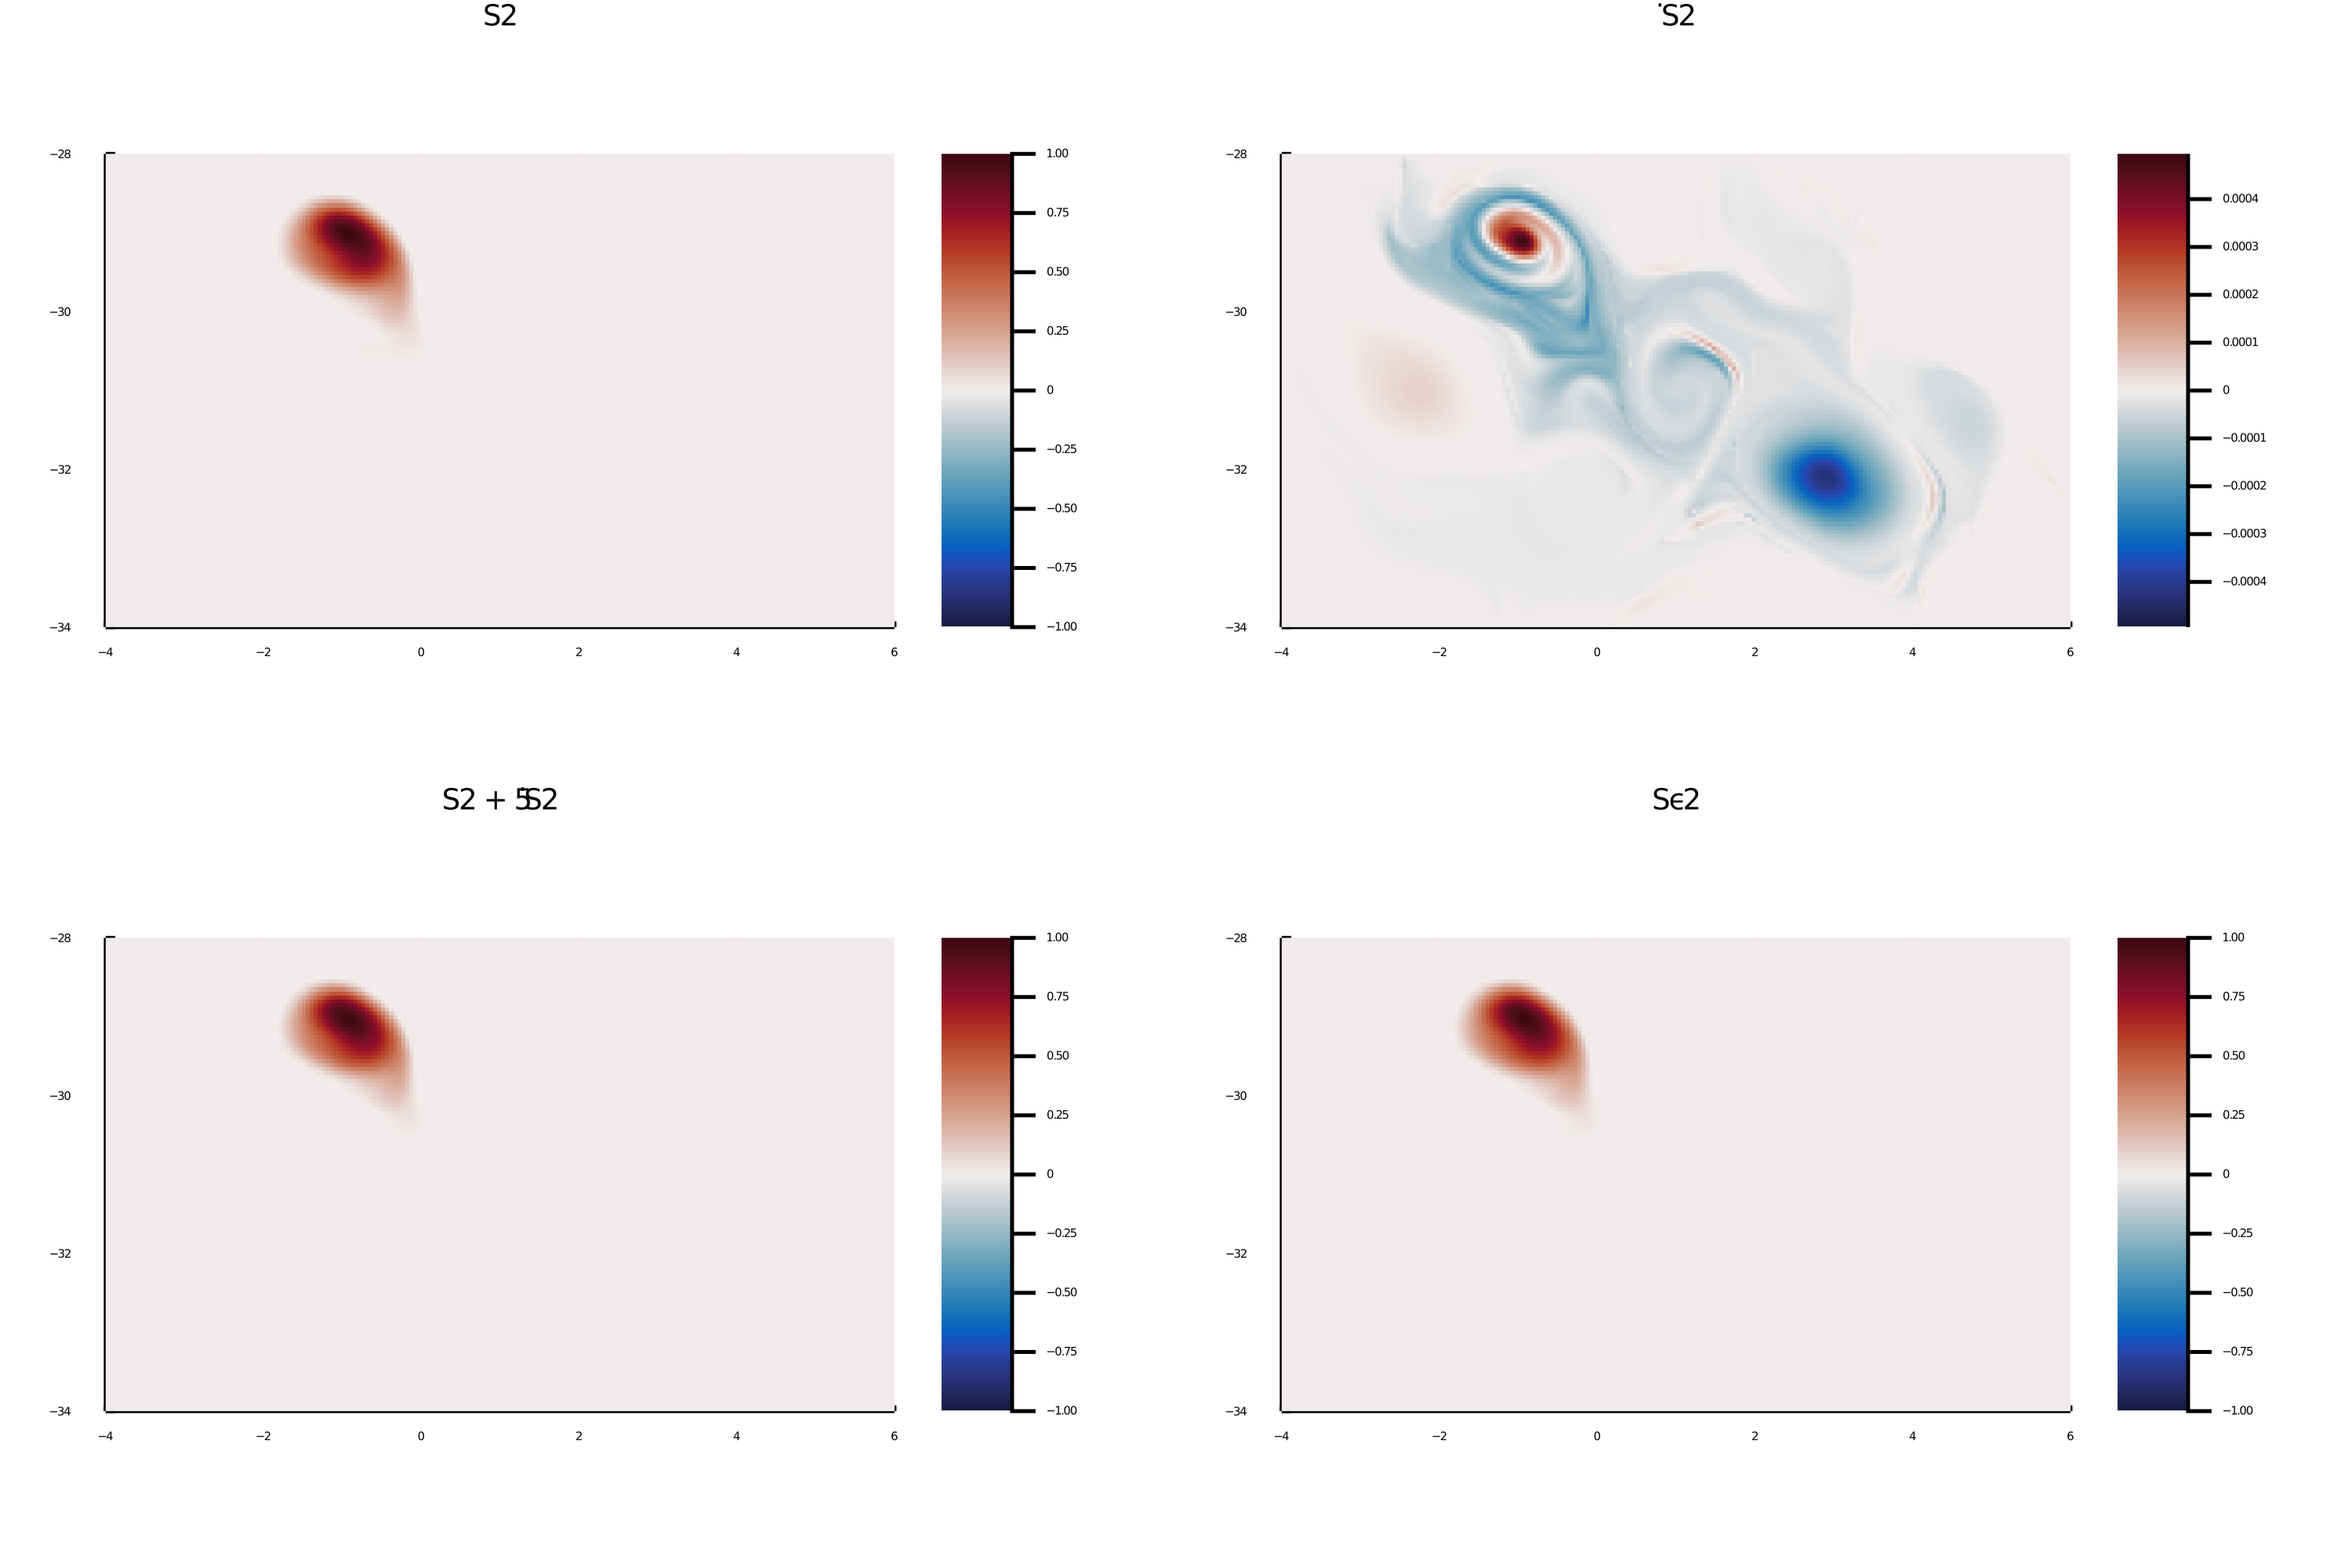

In [93]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, S_dot[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,ev])),maximum(abs.(S_dot[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        lon_resolution, lat_resolution, bdata=bdata,
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        lon_resolution, lat_resolution, bdata=bdata,
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contourplots for SEBA

Levelsets are a better way to actually asses the quality of the predictions visually.

In [94]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value, bdata=bdata,
    n_candidates=1000,min=0)
c_best = level(best_levelset)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",c_best,"\n")

Dynamic Cheeger value:	2.92906837785042
Levelset:		0.06306306306306306


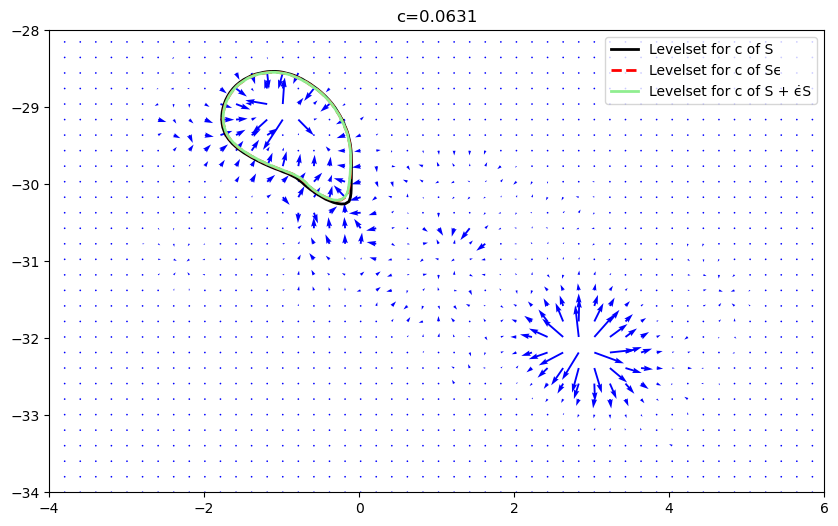

In [95]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,normalizeU(S′[:,ev]),S_dot[:,ev], bdata=bdata)...,ax,scale=0.01,step=4)
curves           = lines(get_levelset(ctx, S[:,ev],c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2, label="Levelset for c of S")
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2, label="Levelset for c of Sϵ")
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2, label="Levelset for c of S + ϵ̇S")
end
ax.set_title("c=$(round(c_best,digits=4))")
ax.legend(loc=1);